<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Fundamentals%20of%20AI%20Agents%20Using%20RAG%20and%20LangChain/LLMs_Rag_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Enhance LLMs using RAG and Hugging Face**


# Setup


In [ ]:
!pip install --user transformers datasets torch faiss-cpu wget

In [1]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import wget
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [4]:
# Helper Functions
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

# Load and Preprocess Data



In [5]:
# Download the Text File
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

wget.download(url, out=filename)

'companyPolicies (1).txt'

In [6]:
# Preprocessing the Data

def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs by split by newline characters
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [7]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



# Building the Retriever: Encoding and Indexing
---

## Encoding texts into embeddings

Let's use the Dense Passage Retriever (DPR) model, specifically the context encoder, to convert your preprocessed text data into dense vector embeddings. These embeddings capture the semantic meanings of the texts, enabling effective similarity-based retrieval. DPR models specialize in dense passage retrieval. They differ from BERT in their training, which focuses on contrastive learning for retrieving relevant passages, while BERT is more general-purpose, handling various NLP tasks.



### 1. Tokenization


In [8]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base') # Identical to bertTokenizer
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [9]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
tokens_info = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

-  `input_ids`: These represent the indices of tokens in the tokenizer's vocabulary. To translate these indices back into readable tokens, you can use the method `convert_ids_to_tokens` provided by the tokenizer.

- `token_type_ids`: These are segment embeddings used to distinguish different sentences or segments within the input. This is particularly useful in tasks that involve multiple types of input, such as question answering, where questions and context may need to be differentiated.

- `attention_mask`: The attention mask indicates which tokens should be attended to by the model. It has a value of 1 for actual tokens in the input sentences and 0 for padding tokens, ensuring that the model focuses only on meaningful data.



In [10]:
# Converting "input_ids" to words back
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


###2. Encoding

In [11]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# Shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tensor([[ 0.0950,  0.0699, -0.2242,  ..., -0.0669, -0.5271,  0.2905],
        [ 0.2918,  0.3407,  0.0421,  ..., -0.4343, -0.5157,  0.1139],
        [ 0.6261, -0.1179, -0.0610,  ...,  0.0211, -0.0856,  0.1127],
        ...,
        [ 0.5983,  0.3700,  0.6134,  ..., -0.2954, -0.4781,  0.3252],
        [ 1.0448,  0.4522, -0.0058,  ..., -0.1293, -0.4701,  0.0488],
        [ 0.6434,  0.0677,  0.0402,  ..., -0.0753, -0.1373,  0.6073]],
       grad_fn=<SliceBackward0>)

   - The `context_tokenizer` takes the first 20 paragraphs and converts each into a sequence of token IDs, formatted specifically as input to a PyTorch model. This process includes:
     - **Padding**: To ensure uniformity, shorter text sequences are padded with zeros to reach the specified maximum length of 256 tokens.
     - **Truncation**: Longer texts are cut off at 256 tokens to maintain consistency across all inputs.
   - The tokenized data is then passed to the `context_encoder`, which processes these token sequences to produce contextual embeddings. Each output embedding vector from the encoder represents the semantic content of its corresponding paragraph, encapsulating key informational and contextual nuances.
   - The encoder outputs a PyTorch tensor where each row corresponds to a different paragraph's embedding. The shape of this tensor, determined by the number of paragraphs processed and the embedding dimensions, reflects the detailed, contextualized representation of each paragraph's content.


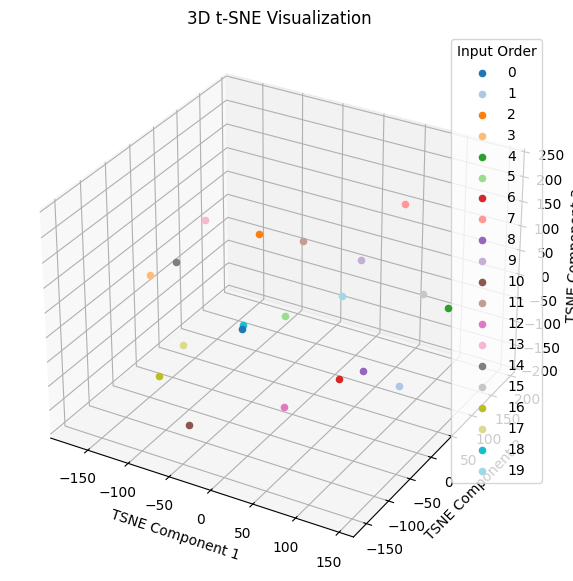

In [13]:
# Applying t-SNE reduces dimensionality of Encoder outputs to two or three dimensions
tsne_plot(outputs.pooler_output.detach().numpy())

This reduction creates a visual representation that preserves the relationships between passages, enabling you to explore clusters of similar passages and discern patterns that might otherwise remain hidden in the high-dimensional space. The resulting plots provide insights into how the model differentiates between different types of passages and reveal the inherent structure within the encoded data.


### 3. Aggregation
 All individual embeddings generated from the texts are then aggregated into a single `NumPy` array with in a compact vector format. This aggregation is essential for subsequent processing steps, such as indexing.

In [14]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256) # Tokenizer
        outputs = context_encoder(**inputs) # Encoder
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy() # Aggregation

context_embeddings = encode_contexts(paragraphs)

In [15]:
len(context_embeddings)

76

In [16]:
context_embeddings[0].shape

(768,)

## Creating and Populating the FAISS Index

#### Overview of FAISS
- **Efficiency**: FAISS is designed for fast similarity search, which is particularly valuable when dealing with large datasets. It is highly suitable for tasks in natural language processing where retrieval speed is critical.
- **Scalability**: It effectively handles large volumes of data, maintaining performance even as dataset sizes increase.

#### Using IndexFlatL2
- **Index type**: `IndexFlatL2` is one of the simplest and most used indexes in FAISS. It computes the Euclidean distance (L2 norm) between the query vector and the dataset vectors to determine similarity. This method is straightforward but very effective for many use cases where the exact distance calculation is crucial.
- **Application**: This type of index is particularly useful in retrieval systems where the task is to find the most relevant documents or information that closely matches the query vector.


In [17]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

# DPR Question Encoder and Tokenizer
---

## Distinguishing DPR question and context components

- **DPR question encoder and tokenizer**: These components are specifically tuned to process and encode queries (questions). The question encoder transforms questions into dense embeddings, which are used to search through a corpus for the most relevant documents. The corresponding tokenizer standardizes the questions to ensure they are correctly formatted for the encoder.

- **DPR context encoder and tokenizer**: In contrast, the context encoder and its tokenizer are focused on encoding the potential answer passages or documents. This encoder creates embeddings from extensive texts, allowing the system to compare these with question embeddings to find the best match.


In [18]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Example Query and Context Retrieval
---


- **D (Distances)**: This array contains the distances between the query embedding and the retrieved document embeddings. The distances measure the similarity between the query and each document, where lower distances indicate higher relevance. These values help determine how closely each retrieved context matches the query.

- **I (Indices)**: This array holds the indices of the paragraphs within the `paragraphs` array that have been identified as the most relevant to the query. These indices correspond to the positions of the paragraphs in the original data array, allowing for easy retrieval of the actual text content.

The combination of `D` and `I` provides both a quantitative measure of relevance and the specific content that is most relevant, enabling a comprehensive response to the user's query.

In [19]:
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.765305 74.71617  84.38809  88.364365 90.287094]]
I: [[74 42 68 31  9]]


In [20]:
# Print out the top 5 relevant context
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

1: 6.	Drug and Alcohol Policy
distance 72.76530456542969

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71617126464844

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38809204101562

4: 9.	Discipline and Termination Policy
distance 88.36436462402344

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28709411621094



In [21]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

# Enhancing Response Generation with LLMs

### GPT2 Model and Tokenizer

- **Encoding user queries**: Utilizing the DPR question encoder and its tokenizer, user queries are transformed into a form that efficiently retrieves related information.
- **Generating relevant answers**: The GPT2 model takes the retrieved information to generate responses that are not only relevant but also contextually rich.



In [22]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [23]:
contexts= "What is a large language model?"
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [24]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [25]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


### Generating Answers Directly From Questions


In [26]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)

    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [27]:
question = "what is mobile policy?"
answer = generate_answer_without_context(question)
print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


### Generating Answers with DPR Contexts


In [28]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [29]:
question = "what is mobile policy?"
_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
print(f"paragraphs indexs {I}")

paragraphs indexs [[20 22  9 67 17]]


In [30]:
top_contexts = [paragraphs[idx] for idx in I[0]]
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


In [31]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta